# Nonlinear Dynamics

Presentation of the neural model supported by kernel regression on nonlinear dynamical dataset.
Dynamics are represented using delay-line, which effectively makes the dataset MISO, with 16 input dimensions (the length of the delay-line).

*Note*: to see how dataset was generated, go to `dataset.ipynb`.

In [1]:
import sys

sys.path.append("..")  # we run from subdirectory, so to access sources append repo root to path

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from pydentification.data.datamodules.simulation import SimulationDataModule
from pydentification.models.modules.feedforward import TimeSeriesLinear
from sklearn import metrics

from src.nonparametric import kernels
from src.nonparametric.memory import ExactMemoryManager
from src.training.module import BoundedSimulationTrainingModule
from src.training.utils import unbatch

In [3]:
sns.set()

# Dataset

Dataset contains 3 columns, independent time-index, inputs and outputs of the dynamical system.

In [4]:
dataset_path = "../data/csv/nonlinear-dynamics.csv"
plot_path = "../data/plots/nonlinear-dynamics/"
model_path = "../models/nonlinear-dynamics-network-parameters.pt"

train_size = 50_000

In [5]:
dataset = pd.read_csv(dataset_path)
dataset.head(3)

,t,u,y
0,0.000,0.000000,0.997225
1,0.001,0.000628,0.971479
2,0.002,0.001257,1.079676


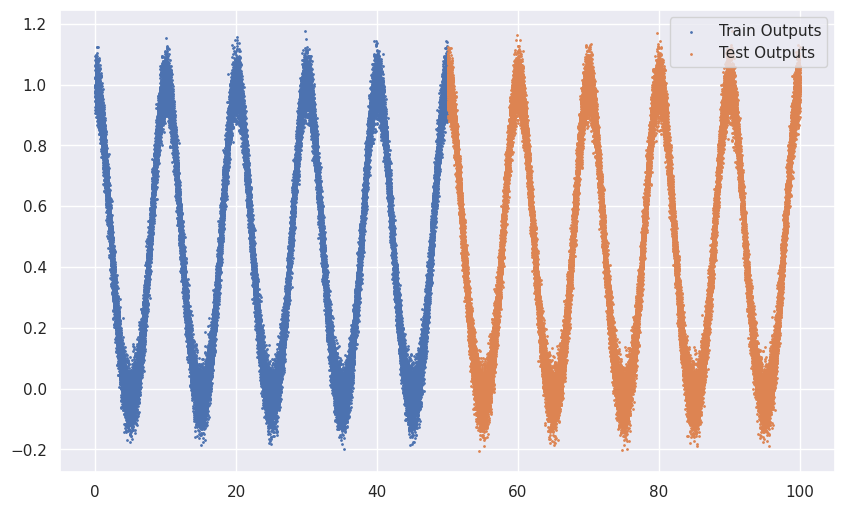

In [6]:
_ = plt.figure(figsize=[10, 6])

_ = plt.scatter(dataset["t"].iloc[:train_size], dataset["y"].iloc[:train_size], s=1)
_ = plt.scatter(dataset["t"].iloc[train_size:], dataset["y"].iloc[train_size:], s=1)

_ = plt.legend(["Train Outputs", "Test Outputs"])
_ = plt.savefig(fr"{plot_path}/system-outputs.png")

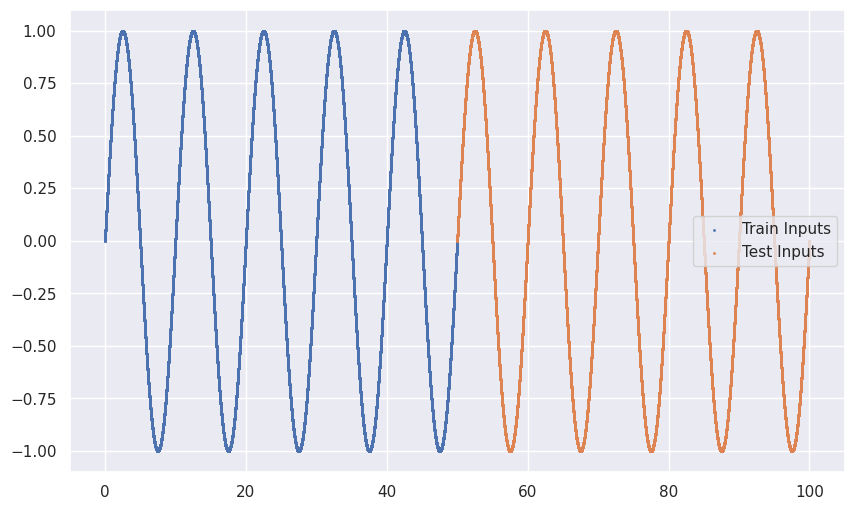

In [7]:
_ = plt.figure(figsize=[10, 6])

_ = plt.scatter(dataset["t"].iloc[:train_size], dataset["u"].iloc[:train_size], s=1)
_ = plt.scatter(dataset["t"].iloc[train_size:], dataset["u"].iloc[train_size:], s=1)

_ = plt.legend(["Train Inputs", "Test Inputs"])
_ = plt.savefig(fr"{plot_path}/system-inputs.png")

# Dataset

In [8]:
dm = SimulationDataModule.from_csv(
    dataset_path=dataset_path,
    input_columns=["u"],
    output_columns=["y"],
    test_size=len(dataset) - train_size,
    batch_size=64,
    validation_size=0.0,
    shift=1,
    forward_input_window_size=16,  # delay-line length
    forward_output_window_size=16,
    forward_output_mask=15,
)

In [9]:
# setup the data for prediction
dm.setup("fit")
dm.setup("predict")

In [10]:
for x, y in dm.train_dataloader():
    print(x.shape, y.shape)
    break

torch.Size([64, 16, 1]) torch.Size([64, 1, 1])


In [11]:
for x, y in dm.test_dataloader():
    print(x.shape, y.shape)
    break

torch.Size([64, 16, 1]) torch.Size([64, 1, 1])


# Model

Create the model from neural network we have trained before.

The settings for kernel regression are selected using hyper-parameter search, which are the best we found for this problem.

In [12]:
network = torch.nn.Sequential(
    TimeSeriesLinear(n_input_time_steps=16, n_input_state_variables=1, n_output_time_steps=8, n_output_state_variables=16),
    torch.nn.LeakyReLU(),
    TimeSeriesLinear(n_input_time_steps=8, n_input_state_variables=16, n_output_time_steps=8, n_output_state_variables=16),
    torch.nn.LeakyReLU(),
    TimeSeriesLinear(n_input_time_steps=8, n_input_state_variables=16, n_output_time_steps=1, n_output_state_variables=128),
    torch.nn.LeakyReLU(),
    TimeSeriesLinear(n_input_time_steps=8, n_input_state_variables=16, n_output_time_steps=1, n_output_state_variables=1),
)

In [13]:
network.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [14]:
model = BoundedSimulationTrainingModule(
    network=network,
    optimizer=torch.optim.Adam(network.parameters()),  # not needed
    lr_scheduler=None,
    bound_during_training=False,
    bound_crossing_penalty=0.0,
    bandwidth=0.5,
    kernel=kernels.box_kernel,
    memory_manager=ExactMemoryManager(),  # using exact memory manager is performant enough in 16 dimensions
    lipschitz_constant=1,
    delta=0.1,
    noise_variance="estimate",  # assume we do not know the variance
    k_neighbours=32,
    power=2,
    memory_device="cpu",
    predict_device="cpu",
)

In [15]:
x, y = unbatch(dm.train_dataloader())
x.shape, y.shape

(torch.Size([49985, 16, 1]), torch.Size([49985, 1, 1]))

In [16]:
model.prepare(x, y)

In [17]:
outputs = model.predict_datamodule(dm, with_targets=True)
type(outputs)

dict

In [18]:
outputs.keys()

dict_keys(['network_predictions', 'nonparametric_predictions', 'lower_bound', 'upper_bound', 'targets'])

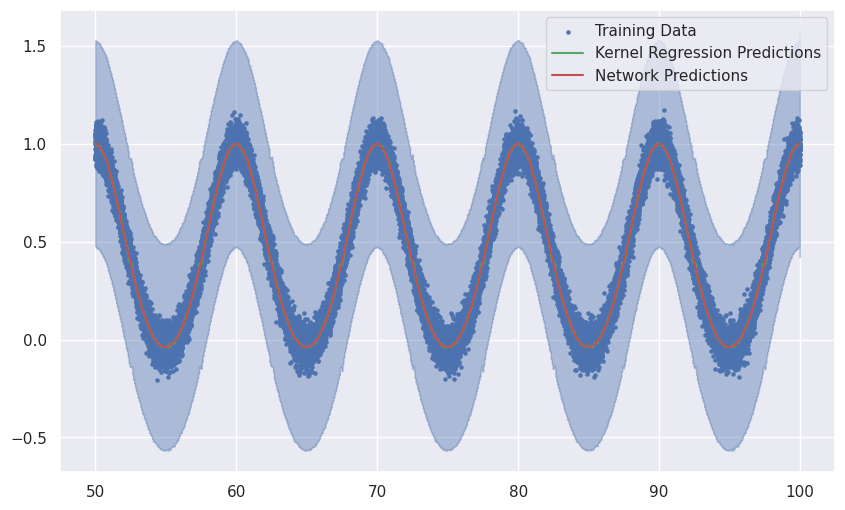

In [19]:
_ = plt.figure(figsize=[10, 6])

# a few time-samples might be lost due to windowing, slice time index from start of test to last available prediction
t = dataset["t"].iloc[train_size : train_size + len(outputs["targets"])].values
index = np.argsort(t)
# create time index sorting predictions, so we can use line plot
t = t[index]

_ = plt.scatter(t, outputs["targets"][index], s=5)
_ = plt.plot(t, outputs["nonparametric_predictions"][index], c="g")
_ = plt.plot(t, outputs["network_predictions"].numpy().flatten()[index], c="r")
_ = plt.fill_between(t, outputs["lower_bound"].numpy().flatten()[index], outputs["upper_bound"].numpy().flatten()[index], color="b", alpha=0.4)

_ = plt.legend(["Training Data", "Kernel Regression Predictions", "Network Predictions"])
_ = plt.savefig(fr"{plot_path}/predictions.png")

In [20]:
def range_ratio_error(error, y_true):
    return error / (y_true.max() - y_true.min())

def report(predictions, targets):
    rmse_network = metrics.root_mean_squared_error(y_true=targets, y_pred=predictions["network_predictions"].numpy().flatten())
    rmse_nonparametric = metrics.root_mean_squared_error(y_true=targets, y_pred=predictions["nonparametric_predictions"].numpy().flatten())
    rmse_bound = metrics.root_mean_squared_error(y_true=targets, y_pred=predictions["lower_bound"].numpy().flatten())

    print(f"RMSE NET:    {rmse_network:.4f}")
    print(f"RMSE KRE:    {rmse_nonparametric:.4f}")
    print(f"RMSE BOUNDS: {rmse_bound:.4f}", end="\n\n")
    print(f"RRR NET:     {range_ratio_error(error=rmse_network, y_true=targets):.2%}")
    print(f"RRR KRE:     {range_ratio_error(error=rmse_nonparametric, y_true=targets):.2%}")
    print(f"RRR BOUNDS:  {range_ratio_error(error=rmse_bound, y_true=targets):.2%}")

In [21]:
report(outputs, outputs["targets"].numpy().flatten())

RMSE NET:    0.0502
RMSE KRE:    0.0505
RMSE BOUNDS: 0.5296

RRR NET:     3.63%
RRR KRE:     3.66%
RRR BOUNDS:  38.34%
